In [161]:
import sys
import matplotlib.pyplot as plt
import optuna
import joblib
import numpy as np
sys.path.insert(0, '../')

from src.utils import ImagesDataset, DataLoader, images_collate, TRANSFORM, REFORM
from src.metrics import PSNR
from src.settings import ParamsConfig
from src.compression import Compressor, JPEGRDSingleImage
from src.trainloop import evaluate

DATA_FOLDER = '../data/cars'
LOG_DIR  = '../experiments/log7' # Выберите каталог эксперимента, из которого нужно брать обученную AutoEncoder-модель
MODEL_TYPE = 'lastmodel'
TRAINED_MODEL = f'{LOG_DIR}/{MODEL_TYPE}.pt'
PARAMS_YAML_PATH = f"{LOG_DIR}/used_config.yaml"
COMPORESSED_IMG_DIR = './compressed_images'
PARAMS = ParamsConfig.get_params_config(PARAMS_YAML_PATH)
ARCH = ParamsConfig.get_architecture_params(PARAMS['latent_dim'], PARAMS['use_maxpool'], base_dir='../')

#### Evaluating

In [ ]:
test_dataset = ImagesDataset('test', DATA_FOLDER, TRANSFORM)
TEST_DATALOADER = DataLoader(
    test_dataset,batch_size=1, shuffle=False,
    num_workers=2, collate_fn=images_collate)

compressor = Compressor(TRAINED_MODEL, PARAMS, ARCH, COMPORESSED_IMG_DIR)

In [ ]:
# оригинал
orig_images = [REFORM(test_dataset[i][1]) for i in range(len(test_dataset))]

# автоенкодер без квантования
_, ae_psnr, ae_images = evaluate(
    compressor.model, TEST_DATALOADER, PARAMS['device'], mode=None)
ae_images = [REFORM(ae_images[i]) for i in range(ae_images.shape[0])]
ae_psnr = ae_psnr['psnr'] 

In [163]:
# автоенкодер c квантованием
compressed_info = [compressor.compress(batch1["images"], str(i)) for i, batch1 in enumerate(TEST_DATALOADER)]
max_x = list(map(lambda item: item[1], compressed_info))
bpp = list(map(lambda item: item[2], compressed_info))

decompressed_images = [compressor.decompress(str(i), mx) for i, mx in enumerate(max_x)]
quand_psnr = [PSNR(target, label, mode=None) for target, label in zip(decompressed_images, orig_images)]

In [164]:
# jpeg квантование
jpeg_info = [JPEGRDSingleImage(image, bpp[i]) for i, image in enumerate(orig_images)]
jpeg_images = list(map(lambda item: item[0], jpeg_info))
jpeg_psnr = list(map(lambda item: item[3], jpeg_info))
jpeg_bpp = list(map(lambda item: item[2], jpeg_info))

In [165]:
psnr_mean_diff = np.mean([jpeg - quant for quant, jpeg in zip(quand_psnr, jpeg_psnr)])
psnr_mean_jpeg = np.mean(jpeg_psnr)
psnr_mean_qunat = np.mean(quand_psnr)
psnr_percent = (psnr_mean_diff * 100) / psnr_mean_jpeg
print(psnr_mean_diff, psnr_percent)
print(psnr_mean_qunat, psnr_mean_jpeg)

0.8806055443502526 2.8895004870452534
29.59544207351129 30.476047617861543


In [166]:
bpp_mean_diff = np.mean([jpeg - quant for quant, jpeg in zip(bpp, jpeg_bpp)])
bpp_mean_jpeg = np.mean(jpeg_bpp)
bpp_mean_quant = np.mean(bpp)
bpp_percent = (bpp_mean_diff * 100) / bpp_mean_jpeg
print(bpp_mean_diff, bpp_percent)
print(bpp_mean_quant, bpp_mean_jpeg)

-0.00034877232142857144 -0.05065342923715936
0.6888950892857143 0.6885463169642857


#### Draw plot

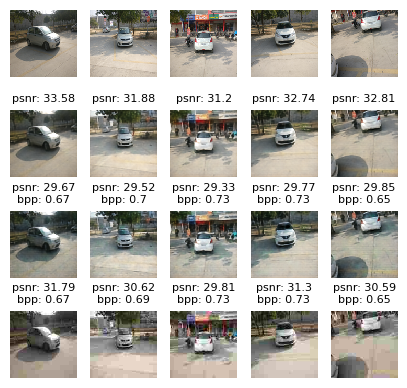

In [160]:
img_count = 5
font_size = 8
save_compare_plot = f'./{MODEL_TYPE}_compare_plot.jpeg'

plt.figure(figsize=(5,5))

for i in range(img_count):
    title = ''
    plt.subplot(4, img_count, i + 1).set_title(title, fontsize=font_size )
    plt.imshow(orig_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(ae_psnr[i],2)}"
    plt.subplot(4, img_count, img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(ae_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(quand_psnr[i],2)}\nbpp: {round(bpp[i],2)}"
    plt.subplot(4,img_count, 2*img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(decompressed_images[i], interpolation='nearest')
    plt.axis(False)

for i in range(img_count):
    title = f"psnr: {round(jpeg_psnr[i],2)}\nbpp: {round(jpeg_bpp[i],2)}"
    plt.subplot(4, img_count, 3*img_count + i + 1).set_title(title, fontsize=font_size )
    plt.imshow(jpeg_images[i], interpolation='nearest')
    plt.axis(False)

plt.savefig(save_compare_plot)
plt.show()